#MP2_report


##組員與分工

組員: 林群佑, 刁一平

|      工作項目      |      分工     |
|:------------------:|:-------------:|
| Trace Code|     林群佑    |
|      功能實作與除錯      |     刁一平    |

##Trace code

####Kernel::Kernel()

In [ ]:
Kernel::Kernel(int argc, char **argv) {
    randomSlice = FALSE;
    debugUserProg = FALSE;
    execExit = FALSE;
    consoleIn = NULL;   // default is stdin
    consoleOut = NULL;  // default is stdout
#ifndef FILESYS_STUB
    formatFlag = FALSE;
#endif
    reliability = 1;  // network reliability, default is 1.0
    hostName = 0;     // machine id, also UNIX socket name
                      // 0 is the default machine id
    for (int i = 1; i < argc; i++) {
        if (strcmp(argv[i], "-rs") == 0) { //-rs <randomSeed>：設置隨機種子，用於初始化偽隨機數生成器
            ASSERT(i + 1 < argc);
            RandomInit(atoi(argv[i + 1]));  // initialize pseudo-random
                                            // number generator
            randomSlice = TRUE;
            i++;
        } else if (strcmp(argv[i], "-s") == 0) { //-s：啟用用戶程序的調試模式
            debugUserProg = TRUE;
        } else if (strcmp(argv[i], "-e") == 0) { //-e <execfile>：指定執行檔案
            execfile[++execfileNum] = argv[++i];
            cout << execfile[execfileNum] << "\n";
        } else if (strcmp(argv[i], "-ee") == 0) { //-ee：設置在所有執行緒完成後結束程式
            // Added by @dasbd72
            // To end the program after all the threads are done
            execExit = TRUE;
        } else if (strcmp(argv[i], "-ci") == 0) { //-ci <consoleIn>：設置自定義的輸入來源
            ASSERT(i + 1 < argc);
            consoleIn = argv[i + 1];
            i++;
        } else if (strcmp(argv[i], "-co") == 0) { //-co <consoleOut>：設置自定義的輸出地方
            ASSERT(i + 1 < argc);
            consoleOut = argv[i + 1];
            i++;
#ifndef FILESYS_STUB
        } else if (strcmp(argv[i], "-f") == 0) { //-f (僅在非 FILESYS_STUB 下可用)：設置文件系統格式化標誌
            formatFlag = TRUE;
#endif
        } else if (strcmp(argv[i], "-n") == 0) { //-n <reliability>：設置網路可靠性
            ASSERT(i + 1 < argc);  // next argument is float
            reliability = atof(argv[i + 1]);
            i++;
        } else if (strcmp(argv[i], "-m") == 0) { //-m <hostName>：設置主機名稱
            ASSERT(i + 1 < argc);  // next argument is int
            hostName = atoi(argv[i + 1]);
            i++;
        } else if (strcmp(argv[i], "-u") == 0) { //-u：顯示使用說明
            cout << "Partial usage: nachos [-rs randomSeed]\n";
            cout << "Partial usage: nachos [-s]\n";
            cout << "Partial usage: nachos [-ci consoleIn] [-co consoleOut]\n";
#ifndef FILESYS_STUB
            cout << "Partial usage: nachos [-nf]\n";
#endif
            cout << "Partial usage: nachos [-n #] [-m #]\n";
        }
    }
}

進到 threads/kernel.cc 觀察 Kernel() 函式

這是用來解析使用者輸入的指令的函式，預設 randomSlice=FALSE, debugUserProg=FALSE, execExit=FALSE, consoleIn=NULL, consoleOut=NULL, 可以在檔案名稱後加上不同指令來改變其值(各種功能設定)

###下方是按照函式使用的流程寫的(從 Kernel::ExecAll() 開始)

###Kernel::ExecAll()

In [ ]:
void Kernel::ExecAll() {
    for (int i = 1; i <= execfileNum; i++) {
        int a = Exec(execfile[i]);
    }
    currentThread->Finish();
    // Kernel::Exec();
}

進到 threads/thread.cc 從 Kernel::ExecAll() 開始

這個就是將所有待辦的程式放入執行(呼叫 Exec() 函式)，執行完後呼叫 currentThread->Finish() 來表示完成所有待辦程式

####Kernel::Exec()

In [ ]:
int Kernel::Exec(char *name) {
    t[threadNum] = new Thread(name, threadNum);
    t[threadNum]->setIsExec();
    t[threadNum]->space = new AddrSpace();
    t[threadNum]->Fork((VoidFunctionPtr)&ForkExecute, (void *)t[threadNum]);
    threadNum++;

    return threadNum - 1;
    /*
        cout << "Total threads number is " << execfileNum << endl;
        for (int n=1;n<=execfileNum;n++) {
                    t[n] = new Thread(execfile[n]);
                    t[n]->space = new AddrSpace();
                    t[n]->Fork((VoidFunctionPtr) &ForkExecute, (void *)t[n]);
                    cout << "Thread " << execfile[n] << " is executing." << endl;
            }
            cout << "debug Kernel::Run finished.\n";
    */
    //  Thread *t1 = new Thread(execfile[1]);
    //  Thread *t1 = new Thread("../test/test1");
    //  Thread *t2 = new Thread("../test/test2");

    //    AddrSpace *halt = new AddrSpace();
    //  t1->space = new AddrSpace();
    //  t2->space = new AddrSpace();

    //    halt->Execute("../test/halt");
    //  t1->Fork((VoidFunctionPtr) &ForkExecute, (void *)t1);
    //  t2->Fork((VoidFunctionPtr) &ForkExecute, (void *)t2);

    //	currentThread->Finish();
    //    Kernel::Run();
    //  cout << "after ThreadedKernel:Run();" << endl;  // unreachable
}

進到 threads/kernel.cc 觀察 Exec() 具體執行什麼

首先建立一個 Process Control Block (在這裡我們可以看到 NachOS 中使用 Thread 這個物件作為 Process Control Block )然後呼叫 setIsExec() ，接著分配空間(呼叫 new AddrSpace() 建立一個 AddrSpace 物件用來管理記憶體)，再呼叫 Fork() ，最後將 threadNum 用來記錄有多少個  Process Control Block 的變數加一

####Thread::setIsExec()

In [ ]:
void setIsExec() { this->isExec = true; }

就只是將當前  Process Control Block ( this ) 的 isExec 變數設為 true 代表正在處理

####AddrSpace::AddrSpace()

In [ ]:
AddrSpace::AddrSpace() {
    pageTable = new TranslationEntry[NumPhysPages];
    for (int i = 0; i < NumPhysPages; i++) {
        pageTable[i].virtualPage = i;  // for now, virt page # = phys page #
        pageTable[i].physicalPage = i;
        pageTable[i].valid = TRUE;
        pageTable[i].use = FALSE;
        pageTable[i].dirty = FALSE;
        pageTable[i].readOnly = FALSE;
    }

    // zero out the entire address space
    bzero(kernel->machine->mainMemory, MemorySize);
}

接著進到 userprog/addrspace.cc 觀察 AddrSpace()

這個函式會將 pageTable 這個變數設為對應映射到的實體位置(目前上面程式碼為未實作完成的狀態)，接著初始化 pageTable 內的各種變數，最後將整個空間設為 0 清理掉所有可能是其他程式遺留下的資料

####Thread::Fork()

In [ ]:
void Thread::Fork(VoidFunctionPtr func, void *arg) {
    Interrupt *interrupt = kernel->interrupt;
    Scheduler *scheduler = kernel->scheduler;
    IntStatus oldLevel;

    DEBUG(dbgThread, "Forking thread: " << name << " f(a): " << (int)func << " " << arg);
    StackAllocate(func, arg);

    oldLevel = interrupt->SetLevel(IntOff);
    scheduler->ReadyToRun(this);  // ReadyToRun assumes that interrupts
                                  // are disabled!
    (void)interrupt->SetLevel(oldLevel);
}


進到 threads/thread.cc 觀察 Fork() 函式

這個函式會呼叫 StackAllocate() 分配 stack 的空間，然後關閉 interrupt 的功能，接著讓 scheduler 知道這個 Process control Block 的程式是準備好執行的(呼叫 scheduler->ReadyToRun(this) )，就是已經將要執行的程式與變數放入 stack 中，最後再回到原本的 interrupt level

####Thread::StackAllocate()

In [ ]:
void Thread::StackAllocate(VoidFunctionPtr func, void *arg) {
    stack = (int *)AllocBoundedArray(StackSize * sizeof(int));

#ifdef PARISC
    // HP stack works from low addresses to high addresses
    // everyone else works the other way: from high addresses to low addresses
    stackTop = stack + 16;  // HP requires 64-byte frame marker
    stack[StackSize - 1] = STACK_FENCEPOST;
#endif

#ifdef SPARC
    stackTop = stack + StackSize - 96;  // SPARC stack must contains at
                                        // least 1 activation record
                                        // to start with.
    *stack = STACK_FENCEPOST;
#endif

#ifdef PowerPC                          // RS6000
    stackTop = stack + StackSize - 16;  // RS6000 requires 64-byte frame marker
    *stack = STACK_FENCEPOST;
#endif

#ifdef DECMIPS
    stackTop = stack + StackSize - 4;  // -4 to be on the safe side!
    *stack = STACK_FENCEPOST;
#endif

#ifdef ALPHA
    stackTop = stack + StackSize - 8;  // -8 to be on the safe side!
    *stack = STACK_FENCEPOST;
#endif

#ifdef x86
    // the x86 passes the return address on the stack.  In order for SWITCH()
    // to go to ThreadRoot when we switch to this thread, the return addres
    // used in SWITCH() must be the starting address of ThreadRoot.
    stackTop = stack + StackSize - 4;  // -4 to be on the safe side!
    *(--stackTop) = (int)ThreadRoot;
    *stack = STACK_FENCEPOST;
#endif

#ifdef PARISC
    machineState[PCState] = PLabelToAddr(ThreadRoot);
    machineState[StartupPCState] = PLabelToAddr(ThreadBegin);
    machineState[InitialPCState] = PLabelToAddr(func);
    machineState[InitialArgState] = arg;
    machineState[WhenDonePCState] = PLabelToAddr(ThreadFinish);
#else
    machineState[PCState] = (void *)ThreadRoot;
    machineState[StartupPCState] = (void *)ThreadBegin;
    machineState[InitialPCState] = (void *)func;
    machineState[InitialArgState] = (void *)arg;
    machineState[WhenDonePCState] = (void *)ThreadFinish;
#endif
}

進到 threads/thread.cc 觀察 StackAllocate() 函式

這個函式就是呼叫 AllocBoundedArray() 分配空間給 stack 和初始化 stack ，而 stack top 需針對不同作業系統有不同處理

####Kernel::ForkExecute

In [ ]:
void ForkExecute(Thread *t) {
    if (!t->space->Load(t->getName())) {
        return;  // executable not found
    }

    t->space->Execute(t->getName());
}

進到 threads/kernel.cc 觀察 ForkExecute() 函式

這個函式是在 Kernel::Exec() 中被 Thread::Fork() 放入 stack 中具體要執行的函式，這個功能就是載入指定的程式(呼叫 t->space->Load() )，如果成功那就執行(呼叫 t->space->Execute() )

####AddrSpace::Load()

In [ ]:
bool AddrSpace::Load(char *fileName) {
    OpenFile *executable = kernel->fileSystem->Open(fileName);
    NoffHeader noffH;
    unsigned int size;

    if (executable == NULL) {
        cerr << "Unable to open file " << fileName << "\n";
        return FALSE;
    }

    executable->ReadAt((char *)&noffH, sizeof(noffH), 0);
    if ((noffH.noffMagic != NOFFMAGIC) &&
        (WordToHost(noffH.noffMagic) == NOFFMAGIC))
        SwapHeader(&noffH);
    ASSERT(noffH.noffMagic == NOFFMAGIC);

#ifdef RDATA
    // how big is address space?
    size = noffH.code.size + noffH.readonlyData.size + noffH.initData.size +
           noffH.uninitData.size + UserStackSize;
    // we need to increase the size
    // to leave room for the stack
#else
    // how big is address space?
    size = noffH.code.size + noffH.initData.size + noffH.uninitData.size + UserStackSize;  // we need to increase the size
                                                                                           // to leave room for the stack
#endif
    numPages = divRoundUp(size, PageSize);
    size = numPages * PageSize;

    ASSERT(numPages <= NumPhysPages);  // check we're not trying
                                       // to run anything too big --
                                       // at least until we have
                                       // virtual memory

    DEBUG(dbgAddr, "Initializing address space: " << numPages << ", " << size);

    // then, copy in the code and data segments into memory
    // Note: this code assumes that virtual address = physical address
    if (noffH.code.size > 0) {
        DEBUG(dbgAddr, "Initializing code segment.");
        DEBUG(dbgAddr, noffH.code.virtualAddr << ", " << noffH.code.size);
        executable->ReadAt(
            &(kernel->machine->mainMemory[noffH.code.virtualAddr]),
            noffH.code.size, noffH.code.inFileAddr);
    }
    if (noffH.initData.size > 0) {
        DEBUG(dbgAddr, "Initializing data segment.");
        DEBUG(dbgAddr, noffH.initData.virtualAddr << ", " << noffH.initData.size);
        executable->ReadAt(
            &(kernel->machine->mainMemory[noffH.initData.virtualAddr]),
            noffH.initData.size, noffH.initData.inFileAddr);
    }

#ifdef RDATA
    if (noffH.readonlyData.size > 0) {
        DEBUG(dbgAddr, "Initializing read only data segment.");
        DEBUG(dbgAddr, noffH.readonlyData.virtualAddr << ", " << noffH.readonlyData.size);
        executable->ReadAt(
            &(kernel->machine->mainMemory[noffH.readonlyData.virtualAddr]),
            noffH.readonlyData.size, noffH.readonlyData.inFileAddr);
    }
#endif

    delete executable;  // close file
    return TRUE;        // success
}

進到 userprog/addrspace.cc 觀察 Load() 函式

首先會打開程式指定的檔案，如果失敗則回傳 FALSE ，然後檢查 NOFF 格式是否合格，接著計算程式所需記憶體空間，並檢查是否有足夠空間執行程式，若有則將程式及資料片段複製進記憶體對應空間，最後關閉檔案並返回 TRUE 代表成功載入資料，而本次作業的實作就在這裡完成虛擬記憶體位置與物理記憶體位置的映射表(目前上方程式碼為未實作的狀態)

####AddrSpace::Execute()

In [ ]:
void AddrSpace::Execute(char *fileName) {
    kernel->currentThread->space = this;

    this->InitRegisters();  // set the initial register values
    this->RestoreState();   // load page table register

    kernel->machine->Run();  // jump to the user progam

    ASSERTNOTREACHED();  // machine->Run never returns;
                         // the address space exits
                         // by doing the syscall "exit"
}

進到 userprog/addrspace.cc 觀察 Execute() 函式

首先，指定當前執行緒要載入的資料在哪(記錄在 Process Control Block ( this )中)，然後初始化暫存器，接著載入 page table 然後執行，如果沒能執行程式則報錯

####Machine::Run()

In [ ]:
void Machine::Run() {
    Instruction *instr = new Instruction;  // storage for decoded instruction
    if (debug->IsEnabled('m')) {
        cout << "Starting program in thread: " << kernel->currentThread->getName();
        cout << ", at time: " << kernel->stats->totalTicks << "\n";
    }
    kernel->interrupt->setStatus(UserMode);
    for (;;) {
        DEBUG(dbgTraCode, "In Machine::Run(), into OneInstruction "
                              << "== Tick " << kernel->stats->totalTicks << " ==");
        OneInstruction(instr);
        DEBUG(dbgTraCode, "In Machine::Run(), return from OneInstruction  "
                              << "== Tick " << kernel->stats->totalTicks << " ==");

        DEBUG(dbgTraCode, "In Machine::Run(), into OneTick "
                              << "== Tick " << kernel->stats->totalTicks << " ==");
        kernel->interrupt->OneTick();
        DEBUG(dbgTraCode, "In Machine::Run(), return from OneTick "
                              << "== Tick " << kernel->stats->totalTicks << " ==");
        if (singleStep && (runUntilTime <= kernel->stats->totalTicks))
            Debugger();
    }
}

進到 machine/mipssim.cc 觀察 Run() 函式

這部分檢查有哪些指令輸入，模擬程式執行的解碼過程 instr 就是 User Program 的某一行程式碼 OneTick() 就是模擬 CPU Clock 往前跑的情形，通常一條指令假設會讓系統前進一個 Clock cycle

####Scheduler::ReadyToRun()

In [ ]:
void Scheduler::ReadyToRun(Thread *thread) {
    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯
    DEBUG(dbgThread, "Putting thread on ready list: " << thread->getName());
    // cout << "Putting thread on ready list: " << thread->getName() << endl ;
    thread->setStatus(READY);
    readyList->Append(thread);
}

進到 threads/scheduler.cc 觀察 ReadyToRun() 函式

這個函式就是將 Process Control Block ( thread )的 setStatus 變數設為 READY ，然後將這個 Process Control Block ( thread )放入 readyList

####Thread::Finish()

In [ ]:
void Thread::Finish() {
    (void)kernel->interrupt->SetLevel(IntOff);
    ASSERT(this == kernel->currentThread);

    DEBUG(dbgThread, "Finishing thread: " << name);
    if (kernel->execExit && this->getIsExec()) {
        kernel->execRunningNum--;
        if (kernel->execRunningNum == 0) {
            kernel->interrupt->Halt();
        }
    }
    Sleep(TRUE);  // invokes SWITCH
    // not reached
}

進到 threads/thread.cc 觀察 Finish() 函式

首先先關閉 interrupt 功能，然後檢查是否所有執行緒已經停止以及當前程式是否完成，當所有執行緒已經停止且當前執行緒工作完成則將紀錄有多少程式在運行的變數減一，當變數為0時，代表已經沒有任何 process 在執行，此時便呼叫 kernel->interrupt->Halt() 結束 NachOS 運作，而若還有 process 在運作則呼叫 Sleep(TRUE) ，代表當前執行緒進入休息狀態

###thread::Sleep()

In [ ]:
void Thread::Sleep(bool finishing) {
    Thread *nextThread;

    ASSERT(this == kernel->currentThread);//檢查現在的 thread 是否為 currentThread ，不是則報錯
    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯

    DEBUG(dbgThread, "Sleeping thread: " << name);
    DEBUG(dbgTraCode, "In Thread::Sleep, Sleeping thread: " << name << ", " << kernel->stats->totalTicks);

    status = BLOCKED;
    // cout << "debug Thread::Sleep " << name << "wait for Idle\n";
    while ((nextThread = kernel->scheduler->FindNextToRun()) == NULL) {
        kernel->interrupt->Idle();  // no one to run, wait for an interrupt
    }
    // returns when it's time for us to run
    kernel->scheduler->Run(nextThread, finishing);
}

進到 threads/thread.cc 觀察 Sleep() 函式

首先先將當前 Process Control Block ( thread )狀態設為 BLOCKED 然後檢查是否還有其他任務，若無則進入空閒狀態，等待 interrupt，直到下個 Process Control Block 出現，當下個 Process Control Block 出現時呼叫 kernel->scheduler->Run() 執行下個 Program

####Scheduler::Run()

In [ ]:
void Scheduler::Run(Thread *nextThread, bool finishing) {
    Thread *oldThread = kernel->currentThread;

    ASSERT(kernel->interrupt->getLevel() == IntOff);//檢查 interrupt 功能是否已經關閉中斷，若無則報錯

    if (finishing) {  // mark that we need to delete current thread
        ASSERT(toBeDestroyed == NULL);
        toBeDestroyed = oldThread;
    }

    if (oldThread->space != NULL) {  // if this thread is a user program,
        oldThread->SaveUserState();  // save the user's CPU registers
        oldThread->space->SaveState();
    }

    oldThread->CheckOverflow();  // check if the old thread
                                 // had an undetected stack overflow

    kernel->currentThread = nextThread;  // switch to the next thread
    nextThread->setStatus(RUNNING);      // nextThread is now running

    DEBUG(dbgThread, "Switching from: " << oldThread->getName() << " to: " << nextThread->getName());

    // This is a machine-dependent assembly language routine defined
    // in switch.s.  You may have to think
    // a bit to figure out what happens after this, both from the point
    // of view of the thread and from the perspective of the "outside world".

    SWITCH(oldThread, nextThread);

    // we're back, running oldThread

    // interrupts are off when we return from switch!
    ASSERT(kernel->interrupt->getLevel() == IntOff);

    DEBUG(dbgThread, "Now in thread: " << oldThread->getName());

    CheckToBeDestroyed();  // check if thread we were running
                           // before this one has finished
                           // and needs to be cleaned up

    if (oldThread->space != NULL) {     // if there is an address space
        oldThread->RestoreUserState();  // to restore, do it.
        oldThread->space->RestoreState();
    }
}

進到 threads/scheduler.cc 觀察 Run() 函式

首先查看當前 process 的 Process Control Block 中的 finish 變數檢查是否已完成，若已完成，則將其放入 toBeDestroyed 這樣之後便會刪除，接著，如果程式是 user program，則須將其資料儲存起來，接著檢查舊 process ( oldThread )是否有 stack overflow ，然後將當前執行緒切換到下一個 Process Control Block 的 process ，並將狀態設為 RUNNING ，再呼叫 SWITCH(oldThread, nextThread) 函式完成當前執行緒工作切換，完成交換後，呼叫 CheckToBeDestroyed() 來檢查是否有執行完成需要被回收掉的程式，最後檢查舊 Process Control Block ( oldThread )是否還有資料(還未完成)，如果有，將資料存回舊 Process Control Block ( oldthread )讓執行緒回來執行 oldthread process 時能從 Process Control Block 中找到資料位置

##Implement page table in NachOS



To impelemet page tabe based on hint, we need the information of the number of remaining physical pages and the whether the page is use or not.


In the addrspace class, two member variables were added: remain, which records the current number of available physical pages, and the bool array used, which tracks whether each physical page is in use, where TRUE indicates it is in use and FALSE indicates it is not.

addrspace.h

In [ ]:
static int remain;
static bool used[];

Initialize the variables in addrspace.cc

In [ ]:
bool AddrSpace::used[NumPhysPages] = {false};
int AddrSpace::reamin = NumPhysPages;

For handelling exception, add **MemoryLimitException** before NumExceptionTypes in machine.h

In [ ]:
enum ExceptionType { NoException,            // Everything ok!
                     SyscallException,       // A program executed a system call.
                     PageFaultException,     // No valid translation found
                     ReadOnlyException,      // Write attempted to page marked
                                             // "read-only"
                     BusErrorException,      // Translation resulted in an
                                             // invalid physical address
                     AddressErrorException,  // Unaligned reference or one that
                                             // was beyond the end of the
                                             // address space
                     OverflowException,      // Integer overflow in add or sub.
                     IllegalInstrException,  // Unimplemented or reserved instr.

                     MemoryLimitException, # 8

                     NumExceptionTypes
};

Since we want to apply function call kernel->machine->**RaiseException**(), so we add **friend class AddrSpace** in the machine class in machine.h

In [ ]:
friend class AddrSpace;

###AddrSpace::AddrSpace()
 In the constructor, since not load into the memory yet,so there is no corresponding physical page, thus I set every **physicalPage** into value -1 at first

In [ ]:
AddrSpace::AddrSpace() {
    pageTable = new TranslationEntry[NumPhysPages];
    for (int i = 0; i < NumPhysPages; i++) {
        pageTable[i].virtualPage = i;  // for now, virt page # = phys page #
        pageTable[i].physicalPage = -1; # not loaded first
        pageTable[i].valid = TRUE;
        pageTable[i].use = FALSE;
        pageTable[i].dirty = FALSE;
        pageTable[i].readOnly = FALSE;
    }
    # zero out the entire memory space
    bzero(kernel->machine->mainMemory, MemorySize);
    }

###AddrSpace::~AddrSpace()

By checking for each physcial page if it is used, if so, then set it to **FALSE**, and add the remain page numbers for each release physical page

In [ ]:
AddrSpace::~AddrSpace() {
    # Free the physical pages and release the page table
    for(unsigned int i = 0; i < NumPhysPages; i++){
        int physPage = pageTable[i].physicalPage;
        if(physPage == -1) continue;
        AddrSpace::used[physPage] = FALSE;
        AddrSpace::remain++;
    }
    delete pageTable;
}

###AddrSpace::Load

First, it checks if the required numPages exceeds the available physical pages (**remain**). If it does, RaiseException() will be called with MemoryLimitException, indicating insufficient memory, and it will return FALSE to signify that the load has failed.

 If the required pages do not exceed the available pages, it will then begin searching for available physical pages one by one, needing to find a total of numPages. For each page found, used is set to TRUE to indicate it is in use, and remain is decreased accordingly

In [ ]:
    if(numPages > AddrSpace::remain){
        kernel->machine->RaiseException(MemoryLimitException, 0);
        return FALSE;
    }

    int j = 0;
    for(unsigned int i = 0; i < numPages; i++){
        for(j = 0;j < NumPhysPages;j++){
            if(AddrSpace::used[j] == FALSE) break;
        }
        pageTable[i].physicalPage = j;
        AddrSpace::used[j] = TRUE;
        AddrSpace::remain--;
    }

AddrSpace::Translate

In [ ]:
ExceptionType
AddrSpace::Translate(unsigned int vaddr, unsigned int *paddr, int isReadWrite) {
    TranslationEntry *pte;
    int pfn;
    unsigned int vpn = vaddr / PageSize;
    unsigned int offset = vaddr % PageSize;
    pte = &pageTable[vpn];
    pfn = pte->physicalPage;
    *paddr = pfn * PageSize + offset;
    return NoException;
}


Based on the translate function in addrspace, we can get:

physical address = pageTable[virtual/PageSize].physicalPage * PageSize + virtual % PageSize

The calculation determines which page in the program's own page table the virtual address falls under and since pageTable[i].virtualPage = i, the corresponding page entry in the page table can be directly accessed through the virtual address.

 Then, it retrieves the physical page ID of this page, multiplies it by the page size, and adds the offset to obtain the physical address.

This approach allows different programs to use non-overlapping segments of pages.

In [ ]:
        executable->ReadAt(
        &(kernel->machine->mainMemory[pageTable[noffH.initData.virtualAddr/PageSize].physicalPage * PageSize + (noffH.code.virtualAddr%PageSize)]),
            noffH.initData.size, noffH.initData.inFileAddr);

###Testing Result

建議指令最後加上 -ee 這樣結束後會 halt 才不會卡住，不加就會發生下面第一張圖的狀況，但也不用擔心，關掉重連就好

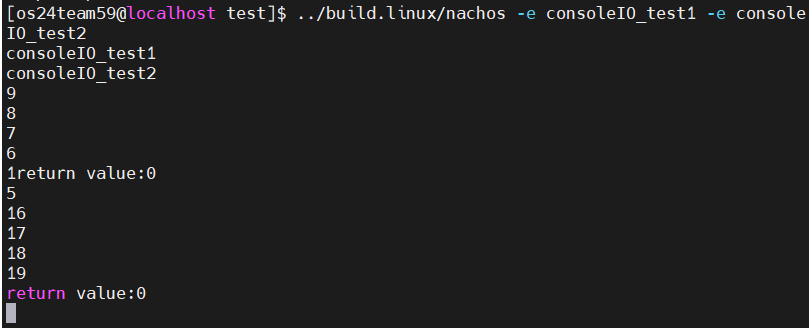

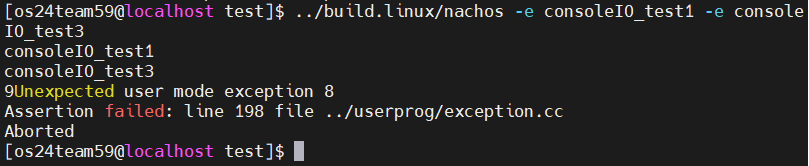

這個問答是後來( 刁一平 )補的，因為沒有批改評語，所以有沒有完全正確不是很確定，但我個人認為應該問題不大

(1) How Nachos allocates the memory space for new thread(process)?


thread.cc 裡的 Fork()會使用 StackAllocate()分配並初始化記憶體空間給新
的thread。


(2) How Nachos initializes the memory content of a thread(process), including
loading the user binary code in the memory?


Nachos 在建立新的thread的時候，這個thread會new一個AddrSpace
來管理他的pageTable，並設定初始值。在之後Load()時，會去打開我們輸
入的binary 檔，且先讀取binary檔最前面固定格式的header進NoffHeader
資料結構中，就可以知道這個binary檔裡面的code、initData、readonlyData
的size、virtualAddr、inFileAddr，最後就可以分別將這些資料從file裡寫進
mainMemory 中。


(3) How Nachos creates and manages the page table?


每個thread 在建立時，都會new一個AddrSpace來管理pageTable，
pageTable 是一個TranslationEntry 陣列，儲存了每個 virtualPage 對應到哪一
個physicalPage，其中也會儲存一些狀態，如valid、dirty、readonly等，
Nachos 可以透過查pageTable，將loagical address 轉換成 physical address。


(4) How Nachos translates address?


translate.cc 裡的 Machine::Translate()會使用 pageTable 或 TLB 把 virtual
address 轉換成physical address。過程中如果有錯誤的話會回傳錯誤類型，
確認沒有錯誤後，會將entry的use設為TRUE，並將算出的physical address
存進physAddr 裡。


(5) How Nachos initializes the machine status (registers, etc) before running a
thread(process)?


在Execute()裡，最後執行Machine::Run()前，會先將currentThread 的
space 指向現在這個Address；並且呼叫InitRegisters()，將program
counter 和 stack 的位置寫進machine 的register，其他register 則設為0
； 再來呼叫RestoreState()，將 machine 的pageTable 和 pageTableSize 設
為現在這個AddrSpace的pageTable和numPages

(6) Which object in Nachos acts the role of process control block?


Thread，裡面包含了machine state、stack、state、userRegisters 等資
料，還有Fork()、Sleep()等功能。


(7) When and how does a thread get added into the ReadyToRun queue of Nachos
CPU scheduler?


Scheduler 會管理 threads 的 ready list，當某個 thread 可以使用 CPU 的
時候就會呼叫ReadyToRun()，把thread的status設成READY，並加進list的
最後面，像是在Fork()、Yield()都會呼叫到ReadyToRun()。